# Degradation Mode Analysis (DMA) Example Notebook

#### Niall Kirkaldy, Feb 2022

### Notes on how to use this notebook

This notebook was made to demonstrate how to use the DMA functions contained within the "NDK_functions_Degradation_Modes_composites" module. There are accompanying full cell datasets at different states of health for the LG M50T cell, as well as 1/2 cell datasets to be used in the fitting process.

If the entire set of folders from GitHub are saved locally, you just need to change the directory/filepath listed in the sys.path function below, and everything else should work.

In [9]:
# This is only here to direct python to find where the 
# Mark Ruihe change 
import sys  ; import pybamm; import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\\Niall_DMA\\Data Analysis Functions"))
sys.path.append(str_path_1) 

import warnings
warnings.simplefilter('ignore', FutureWarning)

# Standard python libraries required for this to work
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.lines import Line2D
import numpy as np
from scipy import optimize

# Some modules I wrote which contain functions used for data processing/analysis
import NDK_functions_Biologic_loading as bl
import NDK_functions_Degradation_Modes as dm
import NDK_functions_Degradation_Modes_composites as dmc

# To graph the results within the Notebook
%matplotlib notebook

In [10]:
# Load reference 1/2 cell datasets for each electrode/component (1 for PE, 2 for NE)
PE_OCV = pd.read_csv('Example Data/Reference half-cell data/LGM50_NMC_PE_lithiation_OCV_v2.csv', index_col=0)
NE_LGM50_OCV = pd.read_csv('Example Data/Reference half-cell data/LGM50_SiGr_NE_delithiation_OCV.csv', index_col=0)
NE_Gr_OCV = pd.read_csv('Example Data/Reference half-cell data/Gr_NE_OCV_delithiation.csv', index_col=0)
NE_Si_OCV = pd.read_csv('Example Data/Reference half-cell data/Si_NE_OCV_delithiation_NEW(pure-Si(100mV)cycle2).csv', index_col=0)

<IPython.core.display.Javascript object>


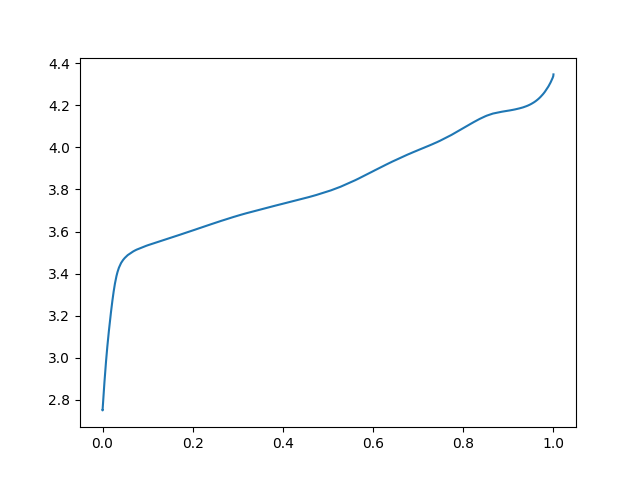

In [11]:
plt.plot(PE_OCV['z'],PE_OCV['OCV'],)

In [12]:
# Load full cell datasets to be analysed (a BoL dataset and some aged cell datasets)
cellBOL = bl.combo_function_fast('Example Data/Reference full-cell data/NDK - LG M50 deg - example - rpt0.mpt')
cellMOL = bl.combo_function_fast('Example Data/Reference full-cell data/NDK - LG M50 deg - example - rpt5.mpt')
cellEOL = bl.combo_function_fast('Example Data/Reference full-cell data/NDK - LG M50 deg - example - rpt10.mpt')
cell_extraDeg = bl.combo_function_fast('Example Data/Reference full-cell data/NDK - LG M50 deg - extra_degraded_example.mpt')
# combine the full cell data into a list
cellData = [cellBOL, cellMOL, cellEOL]

<IPython.core.display.Javascript object>


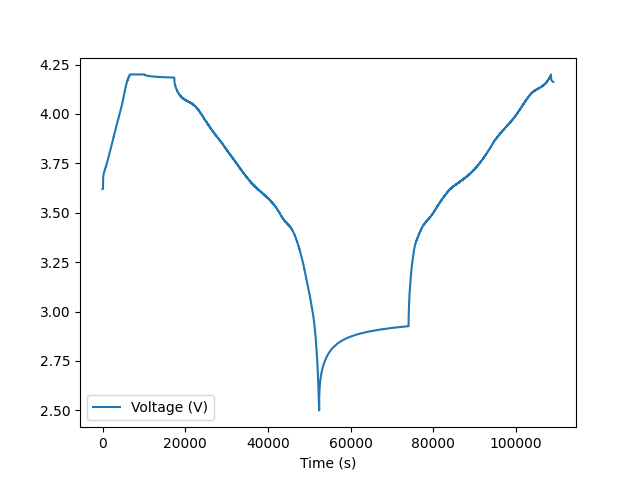

<AxesSubplot:xlabel='Time (s)'>

In [13]:
# Show some of the data (not necessary, but useful to check it has loaded ok)
cellBOL.plot('Time (s)', 'Voltage (V)')

<IPython.core.display.Javascript object>


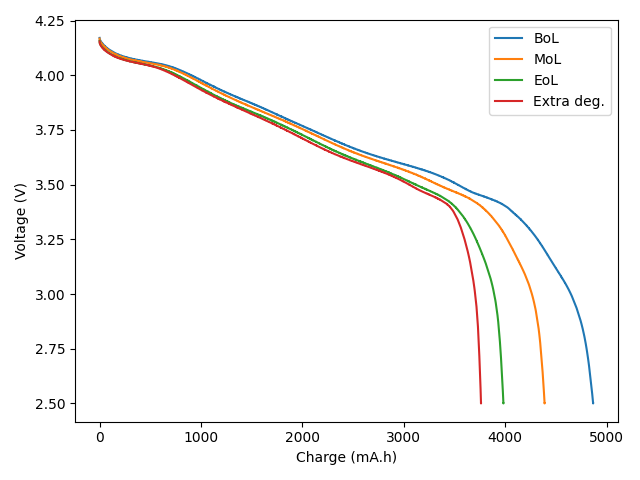

In [14]:
# Plot of the discharge voltage curves for the 3 datasets being analysed
fig_V_curves, ax = plt.subplots()

for cell, label_name in zip(cellData, ['BoL', 'MoL', 'EoL']):
    data_to_plot = cell[cell['Current (mA)'] < 0]
    data_to_plot.plot('Charge (mA.h)', 'Voltage (V)', ax=ax, label=label_name)

cell_extraDeg_plot = cell_extraDeg[cell_extraDeg['Current (mA)'] < 0]
cell_extraDeg_plot.plot('Charge (mA.h)', 'Voltage (V)', ax=ax, label='Extra deg.')
ax.set_ylabel('Voltage (V)')

fig_V_curves.tight_layout()

## 1. Traditional DMA (using full cell data alongside 1 NE and 1 PE curve)


This first section does 'traditional' OCV fitting to determine the degradation modes. These functions are contained within NDK_functions_Degradation_Modes.

The OCV-fitting process involves using individual potential vs SOC datasets for each electrode (PE and NE) to recreate the full cell voltage curve. The optimisation function adjusts 4 variables (upper and lower lithiation fractions of each electrode) to change the calculated full cell voltage curve until it matches the measured full cell curve. The final values of those 4 variables can then be used to calculate the capacities of the PE and NE, as well as the 'offset' between them.

By repeating the process using full cell voltage curves at different SoHs, we can track how those capacities/offsets change as the cell ages. Those changes are then called degradation modes.

A limitation of using this 'traditional' method is that it assumes that there are no changes to the 1/2 potential vs SoH curves as the cell ages, and that ageing simply causes them to 'shrink' in the x-axis (capacity). However, this is not necessarily accurate, particularly for cells which have composite electrodes (i.e. more than one active material present in either the PE or NE). In this case, you are better off using the functions contained in NDK_functions_Degradation_Modes_composites instead. Details of this are listed in the second section.

-----------------------------------
#### Important note: the 'lithiation fraction' calculated for the PE here is actually 1 - lithiation fraction
i.e. if the PE is Lix[Ni0.8Mn0.1Co0.1O2], then here we are talking about 1-x

--------------------------------------

### Adjust values for the 4 fitting parameters and see how the full cell voltage curve changes

Here we make an interactive plot which displays a calculated full cell voltage curve based on input values for our 4 fitting parameters (upper/lower lithitation fractions of each electrode). The calculated voltage curve is plotted alongside the experimentally measured curve to aid understanding.


In [15]:
# Format some data for the graph below. This is not required for the 'DM_calc' function.
discharge_cellBOL = cellBOL.copy()

discharge_cellBOL = discharge_cellBOL[discharge_cellBOL['Current (mA)']<0].loc[:, ['Charge (mA.h)', 'Voltage (V)']]
discharge_cellBOL.reset_index(inplace=True, drop=True)
discharge_cellBOL['SOC (%)'] = 1 - discharge_cellBOL['Charge (mA.h)']/discharge_cellBOL['Charge (mA.h)'].max()

35054


<IPython.core.display.Javascript object>


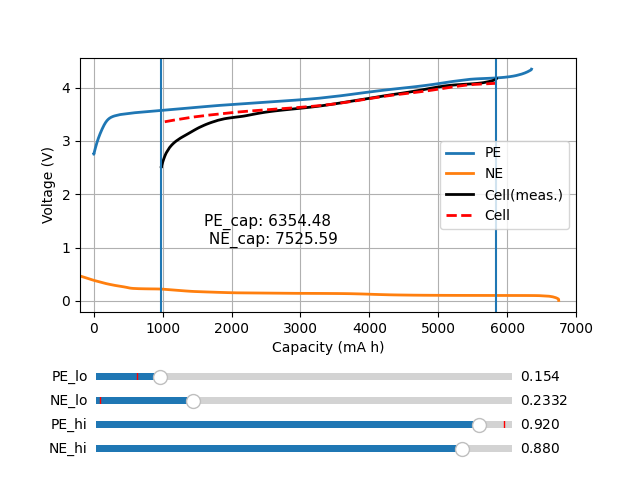

In [16]:
"""An interactive plot showing how changing the lithiation fractions of each electrode affects the voltage curve.
Move the slider bars beneath the graph to adjust each parameter and observe the outcome on the graph"""

# Define initial parameters
init_PE_lo = 0.1
init_NE_lo = 0.01
init_PE_hi = 0.98
init_NE_hi = 0.88

cell_cap = discharge_cellBOL['Charge (mA.h)'].max()
cell_z_values = discharge_cellBOL['SOC (%)']

PE_x_values = PE_OCV['z']*cell_cap / (init_PE_hi - init_PE_lo)
PE_cap = PE_x_values.max()
PE_y_values = PE_OCV['OCV']
NE_caps = (NE_LGM50_OCV['z']*cell_cap / (init_NE_hi - init_NE_lo))
NE_cap = NE_caps.max()
NE_x_values = NE_caps + (init_PE_lo * PE_x_values.max()) - (init_NE_lo * NE_caps.max())
NE_y_values = NE_LGM50_OCV['OCV']
cell_x_values = cell_z_values * cell_cap + (init_PE_lo * PE_x_values.max())
cell_curve, _, _ = dm.calc_full_cell_OCV_standalone(
    [NE_LGM50_OCV, PE_OCV], cell_z_values, init_PE_lo, init_NE_lo, init_PE_hi, init_NE_hi)
cell_y_values = cell_curve['OCV']

cell_meas_x_vals = cell_x_values
cell_meas_y_vals = discharge_cellBOL['Voltage (V)']

fig_DM_example_slider, ax = plt.subplots()

line_PE, = plt.plot(PE_x_values, PE_y_values, lw=2, label='PE')
line_NE, = plt.plot(NE_x_values, NE_y_values, lw=2, label='NE')
line_cell_meas, = plt.plot(cell_meas_x_vals, cell_meas_y_vals, lw=2, label='Cell(meas.)', c='k')
line_cell, = plt.plot(cell_x_values, cell_y_values, lw=2, label='Cell', ls='--', c='r')
lo_line = plt.axvline(cell_x_values.min())
hi_line = plt.axvline(cell_x_values.max())

ax.set_xlabel('Capacity (mA h)')
ax.set_ylabel('Voltage (V)')

ann = ax.annotate(f'PE_cap: {round(PE_cap, 2)}\n NE_cap: {round(NE_cap, 2)}',
    xy=(0.25,0.25), xycoords='axes fraction',
    xytext=(0.25,0.25), textcoords='axes fraction', horizontalalignment='left',
    verticalalignment='bottom', fontsize=11)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.35)

# Make a horizontal slider to control the frequency.
ax_PE_lo = plt.axes([0.15, 0.2, 0.65, 0.03])
PE_lo_slider = Slider(
    ax=ax_PE_lo,
    label='PE_lo',
    valmin=0.001,
    valmax=1.00,
    valinit=init_PE_lo,
)

ax_NE_lo = plt.axes([0.15, 0.15, 0.65, 0.03])
NE_lo_slider = Slider(
    ax=ax_NE_lo,
    label='NE_lo',
    valmin=0.001,
    valmax=1.00,
    valinit=init_NE_lo,
)

ax_PE_hi = plt.axes([0.15, 0.1, 0.65, 0.03])
PE_hi_slider = Slider(
    ax=ax_PE_hi,
    label='PE_hi',
    valmin=0.001,
    valmax=1.00,
    valinit=init_PE_hi,
)

ax_NE_hi = plt.axes([0.15, 0.05, 0.65, 0.03])
NE_hi_slider = Slider(
    ax=ax_NE_hi,
    label='NE_hi',
    valmin=0.001,
    valmax=1.00,
    valinit=init_NE_hi,
)

 
# The function to be called anytime a slider's value changes
def update(val):
    PE_x_values_update = PE_OCV['z']*cell_cap / (PE_hi_slider.val - PE_lo_slider.val)
    PE_capacity = PE_x_values_update.max()
    line_PE.set_data(PE_x_values_update, PE_y_values)
    NE_caps_update = (NE_LGM50_OCV['z']*cell_cap / (NE_hi_slider.val - NE_lo_slider.val))
    NE_capacity = NE_caps_update.max()
    NE_x_values_update = NE_caps_update + (PE_lo_slider.val * PE_x_values_update.max()) - (NE_lo_slider.val * NE_caps_update.max())
    line_NE.set_data(NE_x_values_update, NE_y_values)
    cell_curve_update, _, _ = dm.calc_full_cell_OCV_standalone([NE_LGM50_OCV, PE_OCV], cell_z_values, PE_lo_slider.val, NE_lo_slider.val, PE_hi_slider.val, NE_hi_slider.val)
    cell_x_values_update = cell_z_values * cell_cap + (PE_lo_slider.val * PE_x_values_update.max())
    cell_y_values_update = cell_curve_update['OCV']
    line_cell_meas.set_data(cell_x_values_update, cell_meas_y_vals)
    line_cell.set_data(cell_x_values_update, cell_y_values_update)
    lo_line.set_xdata(cell_x_values_update.min())
    hi_line.set_xdata(cell_x_values_update.max())
    ann.set_text(f'PE_cap: {round(PE_capacity, 2)}\n NE_cap: {round(NE_capacity, 2)}')
    fig.draw()


# register the update function with each slider
PE_lo_slider.on_changed(update)
NE_lo_slider.on_changed(update)
PE_hi_slider.on_changed(update)
NE_hi_slider.on_changed(update)

#lines = [Line2D([0], [0], color=c, linewidth=3) for c in ['C0', 'C1']]
#labels = ['Calculated', 'Measured']
#ax.get_legend().remove()
ax.legend(loc='right')
ax.set_xlim(-200, 7000)
ax.grid(True)

plt.show()

35054


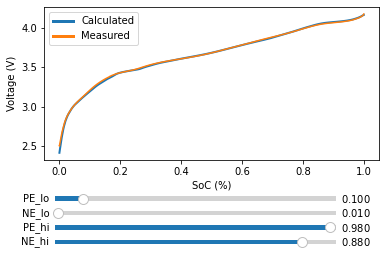

In [9]:
"""An interactive plot showing how changing the lithiation fractions of each electrode affects the voltage curve.
Move the slider bars beneath the graph to adjust each parameter and observe the outcome on the graph"""

# Define initial parameters
init_PE_lo = 0.1
init_NE_lo = 0.01
init_PE_hi = 0.98
init_NE_hi = 0.88

x_values = discharge_cellBOL['SOC (%)']
cell_curve, _, _ = dm.calc_full_cell_OCV_standalone([NE_LGM50_OCV, PE_OCV], x_values, init_PE_lo, init_NE_lo, init_PE_hi, init_NE_hi)
y_values = cell_curve['OCV']

fig_DM_example_slider, ax = plt.subplots()

line, = plt.plot(x_values, y_values, lw=2, label='Calculated')
discharge_cellBOL.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured')
ax.set_xlabel('SoC (%)')
ax.set_ylabel('Voltage (V)')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.35)

# Make a horizontal slider to control the frequency.
ax_PE_lo = plt.axes([0.15, 0.2, 0.65, 0.03])
PE_lo_slider = Slider(
    ax=ax_PE_lo,
    label='PE_lo',
    valmin=0.001,
    valmax=1.00,
    valinit=init_PE_lo,
)

ax_NE_lo = plt.axes([0.15, 0.15, 0.65, 0.03])
NE_lo_slider = Slider(
    ax=ax_NE_lo,
    label='NE_lo',
    valmin=0.001,
    valmax=1.00,
    valinit=init_NE_lo,
)

ax_PE_hi = plt.axes([0.15, 0.1, 0.65, 0.03])
PE_hi_slider = Slider(
    ax=ax_PE_hi,
    label='PE_hi',
    valmin=0.001,
    valmax=1.00,
    valinit=init_PE_hi,
)

ax_NE_hi = plt.axes([0.15, 0.05, 0.65, 0.03])
NE_hi_slider = Slider(
    ax=ax_NE_hi,
    label='NE_hi',
    valmin=0.001,
    valmax=1.00,
    valinit=init_NE_hi,
)

 
# The function to be called anytime a slider's value changes
def update(val):
    cell_curve_update, _, _ = dm.calc_full_cell_OCV_standalone([NE_LGM50_OCV, PE_OCV], x_values, PE_lo_slider.val, NE_lo_slider.val, PE_hi_slider.val, NE_hi_slider.val)
    y_values_update = cell_curve_update['OCV']
    line.set_ydata(y_values_update)
    fig.canvas.draw_idle()


# register the update function with each slider
PE_lo_slider.on_changed(update)
NE_lo_slider.on_changed(update)
PE_hi_slider.on_changed(update)
NE_hi_slider.on_changed(update)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in ['C0', 'C1']]
labels = ['Calculated', 'Measured']
ax.get_legend().remove()
ax.legend(lines, labels)

plt.show()

### Perform the OCV fitting/optimisation process to find the 'best' parameters, then plug into the above function

Here we use the OCV-fitting function called 'stoich_OCV_fit' to determine values for the 4 parameters which result in the best fit to the experimental data (via a non-linear least squares optimisation).

We then plug those fitted parameters into the full cell voltage calculation function used above ('calc_full_cell_OCV_standalone') and plot the results alongside the experimentally measured data.

35054


<AxesSubplot:xlabel='SOC (%)'>

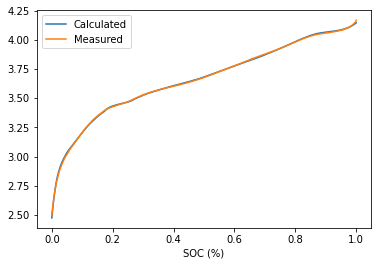

In [21]:
OCV_fitted_params, _, _ = dm.stoich_OCV_fit(NE_LGM50_OCV, PE_OCV, discharge_cellBOL)

cell_curve, _, _ = dm.calc_full_cell_OCV_standalone([NE_LGM50_OCV, PE_OCV], discharge_cellBOL['SOC (%)'], *OCV_fitted_params)

ax=cell_curve.plot('SOC (%)', 'OCV', label='Calculated')
discharge_cellBOL.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured')

In [22]:
print(f'PE_lo: {OCV_fitted_params[0]}\n'
      f'NE_lo: {OCV_fitted_params[1]}\n'
      f'PE_hi: {OCV_fitted_params[2]}\n'
      f'NE_hi: {OCV_fitted_params[3]}')

PE_lo: 0.10766313069168057
NE_lo: 0.011628625622835523
PE_hi: 0.9752992395575527
NE_hi: 0.8921770820581497


### Repeat, but use EoL data instead of BoL

Here we copy what was done above, but using the end of life full cell data instead of the beginning of life stuff.

In [23]:
# Format some data for the graph below. This is not required for the 'DM_calc' function.
discharge_cellEOL = cellEOL.copy()

discharge_cellEOL = discharge_cellEOL[discharge_cellEOL['Current (mA)']<0].loc[:, ['Charge (mA.h)', 'Voltage (V)']]
discharge_cellEOL.reset_index(inplace=True, drop=True)
discharge_cellEOL['SOC (%)'] = 1 - discharge_cellEOL['Charge (mA.h)']/discharge_cellEOL['Charge (mA.h)'].max()

28684


<AxesSubplot:xlabel='SOC (%)'>

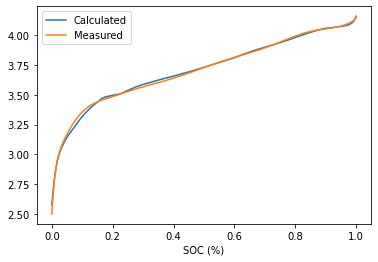

In [24]:
OCV_fitted_params_EoL, _, _ = dm.stoich_OCV_fit(NE_LGM50_OCV, PE_OCV, discharge_cellEOL)

cell_curve_EoL, _, _ = dm.calc_full_cell_OCV_standalone([NE_LGM50_OCV, PE_OCV], discharge_cellEOL['SOC (%)'], *OCV_fitted_params_EoL)

ax=cell_curve_EoL.plot('SOC (%)', 'OCV', label='Calculated')
discharge_cellEOL.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured')

In [25]:
print(f'PE_lo: {OCV_fitted_params_EoL[0]}\n'
      f'NE_lo: {OCV_fitted_params_EoL[1]}\n'
      f'PE_hi: {OCV_fitted_params_EoL[2]}\n'
      f'NE_hi: {OCV_fitted_params_EoL[3]}')

PE_lo: 0.24093267380543323
NE_lo: 0.012004002561298023
PE_hi: 0.9324958903990449
NE_hi: 0.9999911719031949


In [26]:
# Format some data for the graph below. This is not required for the 'DM_calc' function.
discharge_cellExtra = cell_extraDeg.copy()

discharge_cellExtra = discharge_cellExtra[discharge_cellExtra['Current (mA)']<0].loc[:, ['Charge (mA.h)', 'Voltage (V)']]
discharge_cellExtra.reset_index(inplace=True, drop=True)
discharge_cellExtra['SOC (%)'] = 1 - discharge_cellExtra['Charge (mA.h)']/discharge_cellExtra['Charge (mA.h)'].max()

### Repeat, but for a cell which has had lots of silicon loss

Here we copy what was done above, but using the data for a cell which has been cycled specifically to degrade the silicon content.

In [29]:
# Format some data for the graph below. This is not required for the 'DM_calc' function.
discharge_cellExtra = cell_extraDeg.copy()

discharge_cellExtra = discharge_cellExtra[discharge_cellExtra['Current (mA)']<0].loc[:, ['Charge (mA.h)', 'Voltage (V)']]
discharge_cellExtra.reset_index(inplace=True, drop=True)
discharge_cellExtra['SOC (%)'] = 1 - discharge_cellExtra['Charge (mA.h)']/discharge_cellExtra['Charge (mA.h)'].max()

27087


<AxesSubplot:xlabel='SOC (%)'>

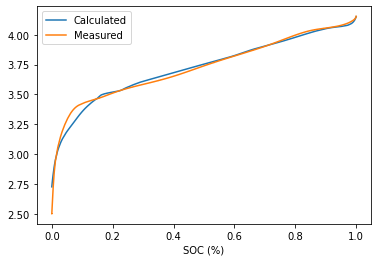

In [30]:
OCV_fitted_params_Extra, _, _ = dm.stoich_OCV_fit(NE_LGM50_OCV, PE_OCV, discharge_cellExtra)

cell_curve_Extra, _, _ = dm.calc_full_cell_OCV_standalone([NE_LGM50_OCV, PE_OCV], discharge_cellExtra['SOC (%)'], *OCV_fitted_params_Extra)

ax=cell_curve_Extra.plot('SOC (%)', 'OCV', label='Calculated')
discharge_cellExtra.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured')

In [ ]:
print(f'PE_lo: {OCV_fitted_params_Extra[0]}\n'
      f'NE_lo: {OCV_fitted_params_Extra[1]}\n'
      f'PE_hi: {OCV_fitted_params_Extra[2]}\n'
      f'NE_hi: {OCV_fitted_params_Extra[3]}')

### The results here are poor

This shows that we cannot recreate the end of life voltage curve using the beginning of life 1/2 cell data. As discussed in the intro, this is largely due to the fact that our cell has a composite negative electrode (graphite and silicon). The two components of the electrode age at different rates, leading to changes in the potential vs SoC curve. This cannot be accounted for using the functions above, but can be if we use the functions contained in 'NDK_functions_Degradation_Modes_composites' (see below in section 2).

However, if we wanted to, we coud still use this traditional method to calculate the DMs using the 'DM_calc' function. You do not have to have run any of the previous code to run this function.


### DMA for the cell at different SoHs

Although the fit of the degraded cell is clearly poor in this case, we can still perform the DMA. The results are obviously inaccurate in this case, as demostrated by negative values of LAM-PE. However, for a cell without a composite electrode the fit should be decent.

Here we use the 'DM_calc' function on the 3 full-cell datasets (BoL, MoL, EoL) to determine the DMs. There are two outputs from this function, both of which are pandas DataFrame objects. The first lists the relevant DMs, with one row for each full-cell dataset analysed. The second contains the individual capacities etc from each component (i.e. one step further back than the DMs).

These are plotted here, with data tables shown underneath.

<AxesSubplot:>

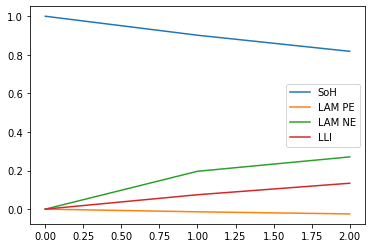

In [31]:

trad_DMs, trad_stoichs = dm.DM_calc(NE_LGM50_OCV, PE_OCV, cellData[0], cellData[1:])

trad_DMs.plot()


In [32]:
trad_DMs

,SoH,LAM PE,LAM NE,LLI
0,1.000000,0.000000,0.00000,0.000000
1,0.901652,-0.013850,0.19621,0.074666
2,0.818224,-0.024772,0.27081,0.134316


In [ ]:
trad_stoichs

## 2. DMA for composites (using full cell data alongside 2 NE and 1 PE curve)


This second section does a modified version of OCV fitting to determine the degradation modes. These functions are contained within NDK_functions_Degradation_Modes.

As before, the OCV-fitting process involves adjusting the upper/lower lithitation fractions of each electrode to recreate the full cell voltage curve. However, in this case we don't use a 'fixed' NE potential vs SoC curve, and instead dynamically create a new curve at each stage of the fitting process.

The potential vs capacity curve of a composite electrode is the sum of the two components (summing Q as a function of V). We can therefore calculate a composite electrode potential vs capacity curve if we have:
* Potential vs SoC curves for the two components (in this case Si and Gr)
* The capacity (or capacity fraction) of each component

We then have: Q<sub>Comp</sub>(V) = Q<sub>Gr</sub>(V) + Q<sub>Si</sub>(V)

and we know that the capacity fractions of graphite and silicon sum to unity: CapFrac<sub>Gr</sub> + CapFrac<sub>Si</sub> = 1

We can then make a composite curve for any desired composition, or we can determine the composition of a measured potential vs capacity curve by doing a non-linear least squares optimisation.

Whereas previously the full cell optimisation function adjusts 4 variables (upper and lower lithiation fractions of each electrode) to change the calculated full cell voltage curve, here we add in another variable (fraction of Gr). By including this in the optimisation, we allow the NE curve to be updated at each iteration of the fit until the full cell voltage curve matches the measured full cell curve. The final values of those 5 variables can then be used to calculate the capacities of the PE and NE, and 'offset', but also the capacity of each component of the NE.

By repeating the process using full cell voltage curves at different SoHs, we can track how those capacities/offsets change as the cell ages. Those changes are then called degradation modes. Instead of just LAM-PE, LAM-NE, and LLI, we now also have LAM-NE-Gr and LAM-NE-Si.

By treating the two components of the composite electrode separately, we overcome the limitation of the 'traditional' method in not allowing the 1/2 cell curves to vary as the cell degrades. This results in a better fit for the experimental data, and also gives us better insight into how the different materials are degrading.


### 1. Plot Potential vs Lithiation fraction curves for a range of compositions

Here we calculate V vs z curves for a range of compositions of NE, from pure graphite (Gr_fraction = 1) to pure silicon (Gr_fraction = 0).

Alongside these, the experimentally measured V vs z curve of the NE from the LG M50 is plotted for reference.

In [ ]:
# The functions used in the next couple of boxes do not need to be used when analysing a full-cell curve
Gr_comp_format, Si_comp_format, V_range_format = dmc.format_el_component_data1(NE_Gr_OCV, NE_Si_OCV)
calculated_curves = [dmc.calc_electrode_curve(Gr_comp_format, Si_comp_format, Gr_fraction, V_range_format) for Gr_fraction in np.arange(0,1.1,0.1)]

fig_calc_composite_curves, ax = plt.subplots()

for comp_curve, frac in zip(calculated_curves, np.arange(0,1.1,0.1)):
    comp_curve.plot(ax=ax, c='C3', alpha=(frac*0.8 + 0.2), label=f'Gr_fract: {frac}')
    
NE_LGM50_OCV.plot('z', 'OCV', ax=ax, c='k', ls='--', label='LG M50 NE')

ax.set_ylabel('Potential vs Li/Li+ (V)')

fig_calc_composite_curves.tight_layout()

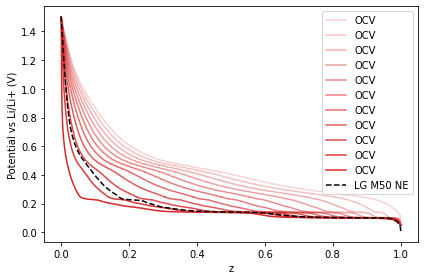

In [34]:
# The functions used in the next couple of boxes do not need to be used when analysing a full-cell curve
Gr_comp_format, Si_comp_format, V_range_format = dmc.format_el_component_data1(NE_Gr_OCV, NE_Si_OCV)
calculated_curves = [dmc.calc_electrode_curve(Gr_comp_format, Si_comp_format, Gr_fraction, V_range_format) for Gr_fraction in np.arange(0,1.1,0.1)]

fig_calc_composite_curves, ax = plt.subplots()

for comp_curve, frac in zip(calculated_curves, np.arange(0,1.1,0.1)):
    comp_curve.plot(ax=ax, c='C3', alpha=(frac*0.8 + 0.2), label=f'Gr_fract: {frac}')
    
NE_LGM50_OCV.plot('z', 'OCV', ax=ax, c='k', ls='--', label='LG M50 NE')

ax.set_ylabel('Potential vs Li/Li+ (V)')

fig_calc_composite_curves.tight_layout()

0.85 0.15000000000000002
0.9349999999999999 0.06500000000000006
0.8698991209624449 0.13010087903755507
0.9568890330586894 0.04311096694131056
0.8768838975195662 0.12311610248043381
0.8716453151017253 0.12835468489827473
0.870335669497265 0.12966433050273496
0.8700082580961499 0.1299917419038501
0.8699264052458712 0.13007359475412883
0.9569190457704583 0.043080954229541724
0.8699332256014451 0.13006677439855485
0.9569265481615896 0.04307345183841038
0.8699400457782055 0.1300599542217945
0.9569340503560261 0.04306594964397392
0.8699536857740989 0.13004631422590107
0.8699434557771789 0.1300565442228211
0.9569378013548968 0.04306219864510319
0.8699502756857194 0.13004972431428063
0.869945160754314 0.13005483924568595
0.9569396768297455 0.043060323170254544
0.8699468657202735 0.13005313427972653
0.8699455869958039 0.13005441300419607
0.9569401456953843 0.043059854304615675
0.8699456935560018 0.13005430644399818
0.8699456136358534 0.13005438636414657
0.8699455936558163 0.13005440634418375


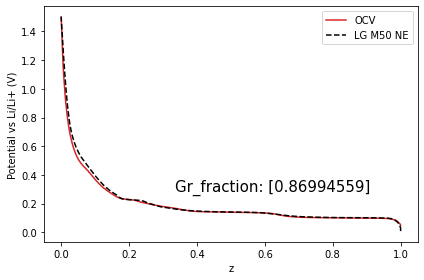

In [35]:
fitted_Gr_fraction, _ = dmc.composite_fit(NE_Gr_OCV, NE_Si_OCV, NE_LGM50_OCV)

fitted_NE_curve = dmc.calc_electrode_curve(Gr_comp_format, Si_comp_format, fitted_Gr_fraction, V_range_format)

fig_fitted_composite_curve, ax = plt.subplots()

fitted_NE_curve.plot(ax=ax, c='C3', label='Fitted Curve')    
NE_LGM50_OCV.plot('z', 'OCV', ax=ax, c='k', ls='--', label='LG M50 NE')

ax.set_ylabel('Potential vs Li/Li+ (V)')
ax.annotate(f'Gr_fraction: {fitted_Gr_fraction}',
            xy=(0.35,0.2), xycoords='axes fraction',
               xytext=(0.35,0.2), textcoords='axes fraction', horizontalalignment='left',verticalalignment='bottom', fontsize=15)


fig_fitted_composite_curve.tight_layout()

### OCV-fitting using separate NE components

Perform the multi-component OCV-fitting, and compare results to the 'traditional' fit and the experimentally measured curves for the beginning of life data.

Below you can use the interactive plot to see how adjusting the **5** parameters changes the shape of the full-cell voltage curve.


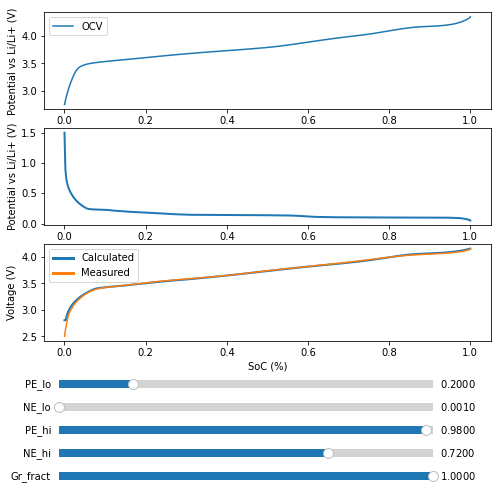

In [36]:
"""An interactive plot showing how changing the lithiation fractions of each electrode affects the voltage curve.
Move the slider bars beneath the graph to adjust each parameter and observe the outcome on the graph"""

# Define initial parameters
init_PE_lo = 0.20
init_NE_lo = 0.001
init_PE_hi = 0.98
init_NE_hi = 0.72
init_Gr = 1.0

x_values = discharge_cellExtra['SOC (%)']
cell_curve, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(NE_Gr_OCV, NE_Si_OCV, PE_OCV, x_values, init_PE_lo, init_NE_lo, init_PE_hi, init_NE_hi, init_Gr)
y_values = cell_curve['OCV']

neg_el_curve = dmc.calc_electrode_curve(Gr_comp_format, Si_comp_format, init_Gr, V_range_format)

fig_DM_example_slider_2, ax = plt.subplots(3,1, figsize=(8,8))

PE_OCV.plot('z', 'OCV', ax=ax[0])
ax[0].set_xlabel('1-lithitation fraction')
ax[0].set_ylabel('Potential vs Li/Li+ (V)')

plt.sca(ax[1])
line_NE, = plt.plot(neg_el_curve.index, neg_el_curve['OCV'], lw=2, label='Calculated')
ax[1].set_xlabel('lithitation fraction')
ax[1].set_ylabel('Potential vs Li/Li+ (V)')

plt.sca(ax[2])
line, = plt.plot(x_values, y_values, lw=2, label='Calculated')
discharge_cellExtra.plot('SOC (%)', 'Voltage (V)', ax=ax[2], label='Measured')
ax[2].set_xlabel('SoC (%)')
ax[2].set_ylabel('Voltage (V)')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.31)

# Make a horizontal slider to control the frequency.
ax_PE_lo = plt.axes([0.15, 0.22, 0.65, 0.03])
PE_lo_slider = Slider(
    ax=ax_PE_lo,
    label='PE_lo',
    valmin=0.0001,
    valmax=1.00,
    valinit=init_PE_lo,
)

ax_NE_lo = plt.axes([0.15, 0.18, 0.65, 0.03])
NE_lo_slider = Slider(
    ax=ax_NE_lo,
    label='NE_lo',
    valmin=0.0001,
    valmax=1.00,
    valinit=init_NE_lo,
)

ax_PE_hi = plt.axes([0.15, 0.14, 0.65, 0.03])
PE_hi_slider = Slider(
    ax=ax_PE_hi,
    label='PE_hi',
    valmin=0.0001,
    valmax=1.00,
    valinit=init_PE_hi,
)

ax_NE_hi = plt.axes([0.15, 0.1, 0.65, 0.03])
NE_hi_slider = Slider(
    ax=ax_NE_hi,
    label='NE_hi',
    valmin=0.0001,
    valmax=1.00,
    valinit=init_NE_hi,
)

ax_Gr = plt.axes([0.15, 0.06, 0.65, 0.03])
Gr_slider = Slider(
    ax=ax_Gr,
    label='Gr_fract',
    valmin=0.0001,
    valmax=1.00,
    valinit=init_Gr,
)

 
# The function to be called anytime a slider's value changes
def update(val):
    neg_el_curve_update = dmc.calc_electrode_curve(Gr_comp_format, Si_comp_format, Gr_slider.val, V_range_format)
    neg_el_curve_update.reset_index(inplace=True)
    neg_el_x_update = neg_el_curve_update['z']
    neg_el_y_update = neg_el_curve_update['OCV']
    line_NE.set_data(neg_el_x_update, neg_el_y_update)
    
    cell_curve_update, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(NE_Gr_OCV, NE_Si_OCV, PE_OCV, x_values, PE_lo_slider.val, NE_lo_slider.val, PE_hi_slider.val, NE_hi_slider.val, Gr_slider.val)
    y_values_update = cell_curve_update['OCV']
    line.set_ydata(y_values_update)
    plt.draw()

# register the update function with each slider
PE_lo_slider.on_changed(update)
NE_lo_slider.on_changed(update)
PE_hi_slider.on_changed(update)
NE_hi_slider.on_changed(update)
Gr_slider.on_changed(update)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in ['C0', 'C1']]
labels = ['Calculated', 'Measured']
ax[2].get_legend().remove()
ax[2].legend(lines, labels)


plt.show()

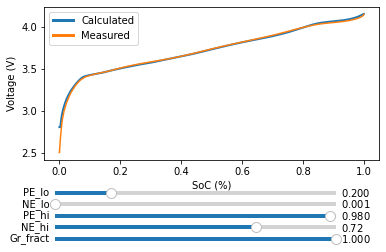

In [37]:
"""An interactive plot showing how changing the lithiation fractions of each electrode affects the voltage curve.
Move the slider bars beneath the graph to adjust each parameter and observe the outcome on the graph"""

# Define initial parameters
init_PE_lo = 0.20
init_NE_lo = 0.001
init_PE_hi = 0.98
init_NE_hi = 0.72
init_Gr = 1.0

x_values = discharge_cellExtra['SOC (%)']
cell_curve, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(NE_Gr_OCV, NE_Si_OCV, PE_OCV, x_values, init_PE_lo, init_NE_lo, init_PE_hi, init_NE_hi, init_Gr)
y_values = cell_curve['OCV']

fig_DM_example_slider_2, ax = plt.subplots()

line, = plt.plot(x_values, y_values, lw=2, label='Calculated')
discharge_cellExtra.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured')
ax.set_xlabel('SoC (%)')
ax.set_ylabel('Voltage (V)')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.35)

# Make a horizontal slider to control the frequency.
ax_PE_lo = plt.axes([0.15, 0.22, 0.65, 0.03])
PE_lo_slider = Slider(
    ax=ax_PE_lo,
    label='PE_lo',
    valmin=0.001,
    valmax=1.00,
    valinit=init_PE_lo,
)

ax_NE_lo = plt.axes([0.15, 0.18, 0.65, 0.03])
NE_lo_slider = Slider(
    ax=ax_NE_lo,
    label='NE_lo',
    valmin=0.001,
    valmax=1.00,
    valinit=init_NE_lo,
)

ax_PE_hi = plt.axes([0.15, 0.14, 0.65, 0.03])
PE_hi_slider = Slider(
    ax=ax_PE_hi,
    label='PE_hi',
    valmin=0.001,
    valmax=1.00,
    valinit=init_PE_hi,
)

ax_NE_hi = plt.axes([0.15, 0.1, 0.65, 0.03])
NE_hi_slider = Slider(
    ax=ax_NE_hi,
    label='NE_hi',
    valmin=0.01,
    valmax=1.00,
    valinit=init_NE_hi,
)

ax_Gr = plt.axes([0.15, 0.06, 0.65, 0.03])
Gr_slider = Slider(
    ax=ax_Gr,
    label='Gr_fract',
    valmin=0.001,
    valmax=1.00,
    valinit=init_Gr,
)

 
# The function to be called anytime a slider's value changes
def update(val):
    cell_curve_update, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(NE_Gr_OCV, NE_Si_OCV, PE_OCV, x_values, PE_lo_slider.val, NE_lo_slider.val, PE_hi_slider.val, NE_hi_slider.val, Gr_slider.val)
    y_values_update = cell_curve_update['OCV']
    line.set_ydata(y_values_update)
    fig.canvas.draw_idle()

# register the update function with each slider
PE_lo_slider.on_changed(update)
NE_lo_slider.on_changed(update)
PE_hi_slider.on_changed(update)
NE_hi_slider.on_changed(update)
Gr_slider.on_changed(update)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in ['C0', 'C1']]
labels = ['Calculated', 'Measured']
ax.get_legend().remove()
ax.legend(lines, labels)

plt.show()

Text(0.35, 0.2, 'Gr_fraction: 0.8768\n Si_fraction: 0.12319999999999998')

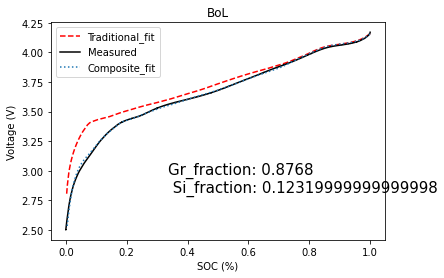

In [38]:
composite_fitted_params, _, _ = dmc.stoich_OCV_fit_multi_comp(NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL)

comp_cell_curve, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL['SOC (%)'], *composite_fitted_params)

fitted_Gr_fract = composite_fitted_params[4].round(4)
fitted_Si_fract = 1-fitted_Gr_fract

ax=cell_curve.plot('SOC (%)', 'OCV', label='Traditional_fit', ls='--', c='r')
discharge_cellBOL.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured', c='k')
comp_cell_curve.plot('SOC (%)', 'OCV', ax=ax, label='Composite_fit', ls=':')

ax.set_title('BoL')
ax.set_ylabel('Voltage (V)')
ax.annotate(f'Gr_fraction: {fitted_Gr_fract}\n Si_fraction: {fitted_Si_fract}',
            xy=(0.35,0.2), xycoords='axes fraction',
               xytext=(0.35,0.2), textcoords='axes fraction', horizontalalignment='left',verticalalignment='bottom', fontsize=15)

### Repeat OCV-fitting for EoL

Same as above but using the end of life data.

Text(0.35, 0.2, 'Gr_fraction: 0.9501\n Si_fraction: 0.0499')

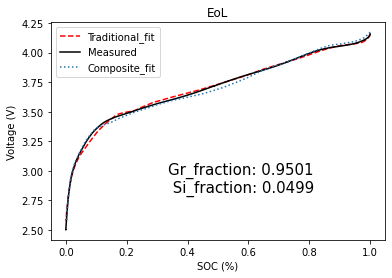

In [48]:
composite_fitted_params_EoL, _, _ = dmc.stoich_OCV_fit_multi_comp(NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellEOL)

comp_cell_curve_EoL, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellEOL['SOC (%)'], *composite_fitted_params_EoL)

fitted_Gr_fract = composite_fitted_params_EoL[4].round(4)
fitted_Si_fract = 1-fitted_Gr_fract

ax=cell_curve_EoL.plot('SOC (%)', 'OCV', label='Traditional_fit', ls='--', c='r')
discharge_cellEOL.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured', c='k')
comp_cell_curve_EoL.plot('SOC (%)', 'OCV', ax=ax, label='Composite_fit', ls=':')

ax.set_title('EoL')
ax.set_ylabel('Voltage (V)')
ax.annotate(f'Gr_fraction: {fitted_Gr_fract}\n Si_fraction: {fitted_Si_fract.round(4)}',
   xy=(0.35,0.2), xycoords='axes fraction',
   xytext=(0.35,0.2), textcoords='axes fraction', horizontalalignment='left',
   verticalalignment='bottom', fontsize=15)

The resulting fit is slightly better than that achieved by the traditional means for this dataset (especially at low SoC). The difference between the two becomes greater when you have greater rates of degradation for one component over another (i.e. if you've lost lost of silicon but not much graphite).

### Repeat OCV-fitting for cell with lots of silicon loss

Same as above but using the data from the cell which has been aged to specifically degrade silicon. Here we expect that the shape of the NE curve has changed dramatically due to a change in Gr:Si composition, and that our new OCV-fitting method will give better results than the 'traditional' one.

Text(0.35, 0.2, 'Gr_fraction: 0.9877\n Si_fraction: 0.0123')

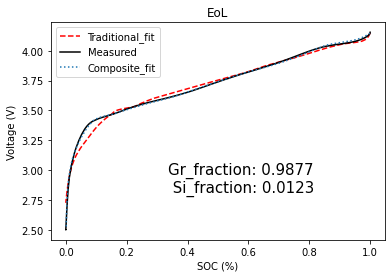

In [40]:
composite_fitted_params_Extra, _, _ = dmc.stoich_OCV_fit_multi_comp(
   NE_Gr_OCV, NE_Si_OCV, PE_OCV, 
   discharge_cellExtra, 
   z_guess=[0.2, 0.001, 0.98, 0.72, 1.0])

comp_cell_curve_Extra, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(
   NE_Gr_OCV, NE_Si_OCV, PE_OCV, 
   discharge_cellExtra['SOC (%)'], 
   *composite_fitted_params_Extra)

fitted_Gr_fract = composite_fitted_params_Extra[4].round(4)
fitted_Si_fract = (1-fitted_Gr_fract).round(4)

ax=cell_curve_Extra.plot('SOC (%)', 'OCV', label='Traditional_fit', ls='--', c='r')
discharge_cellExtra.plot('SOC (%)', 'Voltage (V)', ax=ax, label='Measured', c='k')
comp_cell_curve_Extra.plot('SOC (%)', 'OCV', ax=ax, label='Composite_fit', ls=':')

ax.set_title('EoL')
ax.set_ylabel('Voltage (V)')
ax.annotate(f'Gr_fraction: {fitted_Gr_fract}\n Si_fraction: {fitted_Si_fract}',
   xy=(0.35,0.2), xycoords='axes fraction',
   xytext=(0.35,0.2), textcoords='axes fraction', horizontalalignment='left',
   verticalalignment='bottom', fontsize=15)

In [45]:
print(f'PE_lo: {composite_fitted_params_Extra[0]}\n'
      f'NE_lo: {composite_fitted_params_Extra[1]}\n'
      f'PE_hi: {composite_fitted_params_Extra[2]}\n'
      f'NE_hi: {composite_fitted_params_Extra[3]}\n'
      f'Gr_fract: {composite_fitted_params_Extra[4]}')

PE_lo: 0.21556624591240958
NE_lo: 0.0008762461411628135
PE_hi: 0.9773520969831357
NE_hi: 0.7091443206664323
Gr_fract: 0.9877467649632194


The resulting fit is definitely better than that achieved by the traditional means for this dataset (especially at low SoC). The fitted parameters indicate that the silicon content in the NE has reduced from about **15%** at BoL to only **1%** here. That's quite a lot of LAM-NE-Si...

-------------
***Note:***
The optimisation can sometimes get stuck in a local minimum if the initial guess of parameters isn't good, but performs much more robustly if we carry forward parameters from the previous SoH.

-----------



### DMA using the composite fit

The "DM_calc_multi_comp_long" function outputs 3 pandas DataFrame objects. They contain:
* **DM_data**: Values such as LAM and LLI for each of the full cell datasets input into the function. Each row is a different SoH, all relative to the BoL values.
* **stoic_data**: Values of capacity and offset of each of the electrode components (1 step back from DMs).
* **error_data**: RMSE values (in Volts) for the fit at each SoH.

In [42]:
# Analayse the 3 datasets using the DMA function
DM_data, stoic_data, error_data = dmc.DM_calc_multi_comp_long(
    NE_Gr_OCV, NE_Si_OCV, PE_OCV, 
    cellData[0], cellData[1:])

0
1


In [47]:
# Inspect one of the output DataFrames
DM_data.head()

,SoH,LAM PE,LAM NE_tot,LAM NE_Gr,LAM NE_Si,LLI
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.901652,0.098918,0.161642,0.112779,0.509542,0.107459
2,0.818224,0.075375,0.227429,0.187798,0.509598,0.169382


### Differences from using the 'traditional' method

We can see that that values of our DMs are different to the ones computed previously using the 'traditional' method, and that we no longer have issues of negative LAM occuring. We also now have two new outputs, LAM-NE-Gr and LAM-NE-Si, so we can see how the two components of the NE have aged. Here we see that the silicon degrades to a much larger extent than the graphite.

### Note
In this example, we don't know what has happened to the cell between each of the 3 stages of SoH (i.e. the number of ageing cycles or charge throughput etc.). However, if you do know that, you can replace the x-axis of the plot below to get a more representative view.

In [ ]:
# Plot the output data from the DMA function
fig_DMA_output, ax = plt.subplots(3,1, sharex=True, figsize=(8,8))

DM_data.plot(ax=ax[0], marker='o')
stoic_data.plot(ax=ax[1], marker='o')
error_data.plot(ax=ax[2], marker='o')

ax[0].set_ylabel('DM Fraction')
ax[1].set_ylabel('Capacity (mA h)')
ax[2].set_ylabel('RMSE (V)')
ax[2].set_xlabel('Dataset number')

fig_DMA_output.tight_layout()

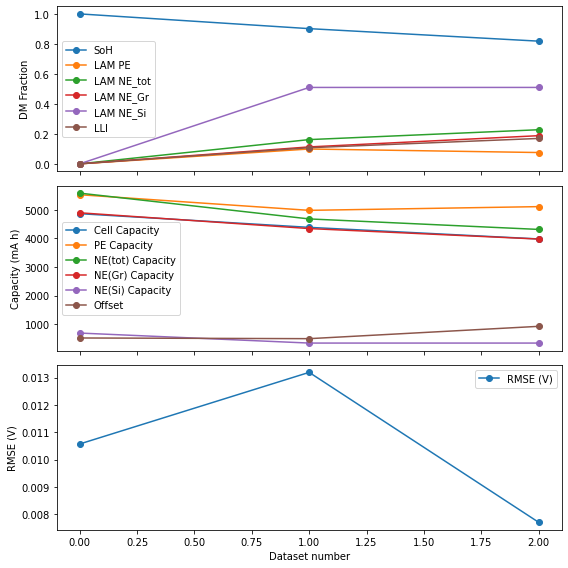

In [44]:
# Plot the output data from the DMA function
fig_DMA_output, ax = plt.subplots(3,1, sharex=True, figsize=(8,8))

DM_data.plot(ax=ax[0], marker='o')
stoic_data.plot(ax=ax[1], marker='o')
error_data.plot(ax=ax[2], marker='o')

ax[0].set_ylabel('DM Fraction')
ax[1].set_ylabel('Capacity (mA h)')
ax[2].set_ylabel('RMSE (V)')
ax[2].set_xlabel('Dataset number')

fig_DMA_output.tight_layout()